In [1]:
import warnings
warnings.filterwarnings(action='ignore')

from glob import glob
import json

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

In [2]:
def load_data(file, sheet_name):
    return pd.read_excel(file, sheet_name=sheet_name)

In [3]:
def load_all_data():
    files = glob('/Users/sabin/Documents/Project/뉴스와 소셜데이터 기반 이슈 분석 및 시각화/Trend-analysis/dataset/임대차3법(54,752건)/*.xlsx')
    df = pd.DataFrame()
    for file in files:
        df = df.append(load_data(file, '뉴스-인기순'))
    return df

news = load_all_data()

## 뉴스-인기순 Sheet

In [4]:
news.isna().sum()

Unnamed: 0     0
Unnamed: 1     0
Unnamed: 2     0
Unnamed: 3     0
Unnamed: 4    15
dtype: int64

In [5]:
news.columns = news.iloc[0]
news.drop(0, inplace=True, axis=0)
news = news.dropna(axis=0, how='any')
news = news[~news['내용'].str.contains('http')]
news = news[news['내용'].str.contains('[가-힣]')]
news = news[news['내용'].str.len() < 1000]

print(news.shape)
news.head()

(3999, 5)


,작성일,작성자,댓글수,제목,내용
1,2020/07/20,조선일보,8744,어? 갑자기 왜 사람들이 '문재인 내려와'를 검색하죠?,'문재인 내려와'. 20일 오후 포털사이트 네이버 실시간 급상승 검색어에 이런 내용...
9,2020/11/20,연합뉴스,3496,"진선미 ""아파트 환상 버려야…임대로 주거 질 실현 확신""(종합)","임대차3법 보완 지적엔 ""제도 안착 시간 필요…어려움 겪는 분들께 죄송"" 민주당 진..."
17,2020/11/20,조선일보,3108,與진선미 “아파트 환상 버리면 임대주택으로도 충분히 주거 질 확보”,임대주택 둘러본 뒤 “내 아파트와 전혀 차이 없다” 더불어민주당 미래주거추진단 진선...
18,2020/07/25,국민일보,3259,“나라가 니꺼냐” 촛불 정부 앞에 ‘부동산 촛불’ 켜진다,"부동산 대책 피해자 모임, 25일 저녁 7시부터 집회 ‘촛불 정부’를 자임하는 문재..."
22,2020/12/04,조선일보,2701,[단독]신임 국토부장관 “현정부 주거복지 최고”,변창흠내정자 최근 발언 “비판여론 박탈감때문” “이전 정부 비해 제일 잘해” ...


In [6]:
def tfdif(corpus):
    cv = CountVectorizer(ngram_range=(1, 2), max_features=1000)
    document_term_matrix = cv.fit_transform(corpus)

    tf = pd.DataFrame(document_term_matrix.toarray(), columns=cv.get_feature_names())  # TF (Term Frequency)

    D = len(tf)
    df = tf.astype(bool).sum(axis=0)
    idf = np.log((D+1) / (df+1)) + 1             # IDF (Inverse Document Frequency)

    # TF-IDF (Term Frequency-Inverse Document Frequency)
    tfidf = tf * idf                      
    tfidf = tfidf / np.linalg.norm(tfidf, axis=1, keepdims=True)
    
    return tfidf


## Key phrase
* ngram_range=(2,5)

In [7]:
def get_tfidf(ngram_range=(2,5), max_features=1000):
    vocab = {}
    tfidf = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    
    for content in news['내용']:
        if len(content) < 500:
            continue
        new_tfidf = tfidf.fit_transform(content.split(','))
        new_tfidf = new_tfidf.toarray()
        new_tfidf = pd.DataFrame(new_tfidf, columns=tfidf.get_feature_names())
        new_tfidf = new_tfidf.sum(axis=0).sort_values(ascending=False)[:10]
        for key, value in new_tfidf.items():
            if key in vocab:
                vocab[key] += value
            else:
                vocab[key] = value
        
    return vocab

In [8]:
vocab = get_tfidf(ngram_range=(2,4))

In [9]:
vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

In [12]:
vocab[11:30]

[('전월세 상한제', 11.11997781461566),
 ('서울 아파트', 10.158680230228054),
 ('실수요자 보호', 10.0),
 ('타협의 정치', 10.0),
 ('김현미 국토교통부', 8.838545486503511),
 ('동영상 뉴스', 8.679415698096054),
 ('월세 상한제', 8.48665896270393),
 ('김상조 청와대', 6.682336957429225),
 ('한국토지주택공사 lh', 6.608931442204987),
 ('한국개발연구원 kdi', 6.288675134594813),
 ('국회에서 열린', 6.226931307796951),
 ('주택공급을 확대하며', 6.0),
 ('대출 규제', 6.0),
 ('부동산 정책', 5.481589122524673),
 ('월세 신고제', 5.19212218794031),
 ('yna co', 5.126717590614795),
 ('가격 움직임', 5.0),
 ('yna co kr', 4.864570009715202),
 ('국토교통부 장관', 4.77551335208706)]

In [13]:
with open('tfdif_뉴스인기순_vocab_keyphrase.json', 'w') as f:
    json.dump(vocab[11:], f)

(-0.5, 799.5, 599.5, -0.5)

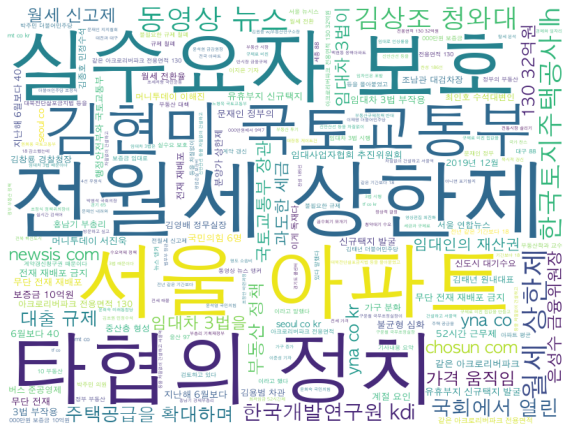

In [14]:
wordcloud = WordCloud(background_color='white', width=800, height=600, font_path='/Library/Fonts/AppleGothic.ttf').generate_from_frequencies(dict(vocab[11:]))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis('off')

In [16]:
wordcloud.to_file('tfidf_뉴스인기순_wordcloud_keyphrase.png')

## Key Word

In [15]:
keyword = get_tfidf(ngram_range=(1,2))
keyword = sorted(keyword.items(), key=lambda x: x[1], reverse=True)
keyword

[('임대차', 207.61877336910462),
 ('부동산', 188.49384965712332),
 ('있다', 95.06935867290086),
 ('월세', 92.38523653710011),
 ('전세', 85.44003961228223),
 ('서울', 83.93840164168057),
 ('무단전재', 83.11879855882098),
 ('금지', 80.1596097583415),
 ('기자', 69.92852877597345),
 ('재배포', 66.12569638385911),
 ('재배포 금지', 64.91022013140278),
 ('무단전재 재배포', 63.78943025924097),
 ('의원은', 62.50953455107274),
 ('3법', 59.74732435924702),
 ('임대차 3법', 56.911521328513665),
 ('아파트', 51.35754284045268),
 ('전월세', 47.98670098854024),
 ('이라고', 43.65598981494334),
 ('국민의힘', 39.89958470698616),
 ('국회', 33.97243643534358),
 ('것으로', 33.36385187070198),
 ('했다', 32.09723930772958),
 ('말했다', 31.97077368101108),
 ('주택', 31.03183943322875),
 ('정부', 30.123346802774194),
 ('장관은', 30.03015982236186),
 ('보증금', 28.695111240577003),
 ('문재인', 27.378274265006635),
 ('카카오톡', 27.3439770659695),
 ('tv조선제보', 27.135462651912427),
 ('카카오톡 tv조선제보', 27.135462651912427),
 ('있습니다', 25.59751941122785),
 ('더불어민주당', 24.317486661752483),
 ('변형', 24.0),
 ('

In [17]:
with open('tfdif_뉴스인기순_keyword.json', 'w') as f:
    json.dump(keyword, f)

(-0.5, 799.5, 599.5, -0.5)

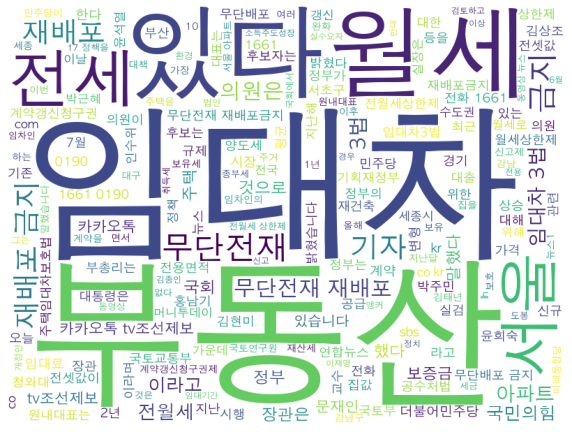

In [18]:
wordcloud = WordCloud(background_color='white', width=800, height=600, font_path='/Library/Fonts/AppleGothic.ttf').generate_from_frequencies(dict(keyword))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis('off')

In [19]:
wordcloud.to_file('tfid_뉴스인기순_wordcloud_keyword.png')

# TFDIF

We couldn't figure the relationship between the words linearly

as we can see in the graph above